In [1]:
# General imports
import numpy as np
import json

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import differential_evolution

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# custom module
from susy_qm import calculate_Hamiltonian

aer_sim = AerSimulator(method='statevector')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

In [2]:
#potential = 'QHO'
potential = 'AHO'
#potential = 'DW'
cut_off = 4

In [3]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [4]:
ansatz = RealAmplitudes(num_qubits=hamiltonian.num_qubits, reps=1)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [5]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    #result = estimator.run(pubs=[pub], precision=0.01).result()
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    #cost_history_dict["iters"] += 1
    #cost_history_dict["prev_vector"] = params
    #cost_history_dict["cost_history"].append(energy)
    #if cost_history_dict['iters'] % 100 == 0:
    #    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [6]:
num_params = ansatz.num_parameters
bounds = [(0, 2 * np.pi) for _ in range(num_params)]

tol=1e-3
max_iterations = 500
strategy = 'best1bin'
popsize = 15

In [7]:
energies = []
x_values = []

backend=aer_sim
estimator = Estimator(mode=backend)

for i in range(1):

    if i % 10 == 0:
        print(f"Run: {i}")

    res = differential_evolution(cost_func, 
                                    bounds, 
                                    args= (ansatz_isa, hamiltonian_isa, estimator),
                                    maxiter=max_iterations, 
                                    atol=tol,
                                    strategy=strategy, 
                                    popsize=popsize)
    energies.append(res.fun)
    x_values.append(res.x)

Run: 0


In [8]:
energies

[-0.4090644357813712]

In [17]:
min(cost_history_dict['cost_history'])

-55.492001687977655

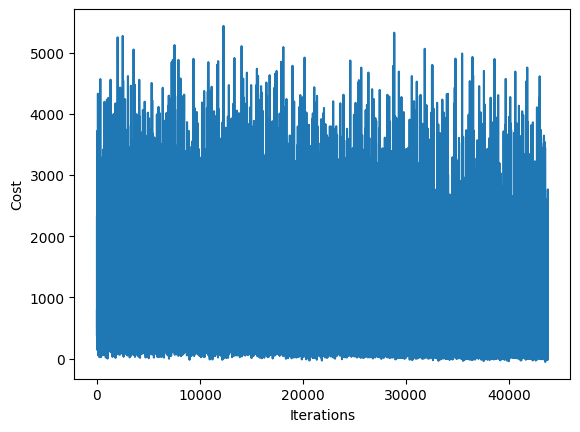

In [18]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [11]:
run = {
    'potential': 'AHO',
    'cutoff': 16,
    'ansatz': 'RealAmplitudes',
    'num_sessions': 100,
    'backend': 'aer_simulator',
    'estimator_shots': 10000,
    'min_function': {'name': 'basinhopping',
                     'args': {'minimizer_kwargs': {'method': "COBYLA",
                                                    "args": ('ansatz_isa', 'hamiltonian_isa', 'estimator'),
                                                    "options": {'maxiter':1000}},   
                                'niter': 3,
                                'T': 0.25}
                    },
    'results': energies,
    'x_values': [x.tolist() for x in x_values]
}

In [12]:
path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\AHO\AHO_16.json"
# Save the variable to a JSON file
with open(path, 'w') as json_file:
    json.dump(run, json_file, indent=4)

In [13]:
n_values = [2, 4, 8, 16]
data_dict = {}

base_path = r"C:\Users\Johnk\OneDrive\Desktop\PhD 2024\Quantum Computing Code\Quantum-Computing\Qiskit\SUSY VQE\Files\AHO\AHO_{}.json"

for n in n_values:
    file_path = base_path.format(n)
    with open(file_path, 'r') as json_file:
        data_dict[f'c{n}'] = json.load(json_file)

In [14]:
for c in data_dict.keys():
    res = [x for x in data_dict[c]['results']]
    print(c)
    print("Min: ", min(res))
    print("Avg: ", np.mean(res))

c2
Min:  -0.4375
Avg:  -0.4374975
c4
Min:  -0.24108233132392165
Avg:  -0.1333196277260035
c8
Min:  -0.8417416284745765
Avg:  1.6553677447548585
c16
Min:  -28.926533464003278
Avg:  3.549705413130431
